# CS 6330
## Final Project
## Distinguish Between Three Walkers
### Robert Burkhardt
### Dan Olson
### Rich Lukas
### 2/14/23

### Load Libraries

In [1]:
from collections import defaultdict as dd
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from ModelAuto.Multicollinearity import handel_Multico_VIF
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from numpy import *
from numpy import linalg as LA
from patsy import dmatrices
from pylab import *
from scipy import signal
from scipy.sparse import csr_matrix, find
from scipy.stats import chisquare
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics.cluster import rand_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import random
import scipy as sci
import scipy.stats as stats
import seaborn as sns
import sklearn
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import statistics 
import statsmodels.api as sm
import tensorflow as tf
import time
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category
print("Libraries Loaded")

Libraries Loaded


## Create Data Frames

In [2]:
# !!! ONLY RUN THIS CELL ONCE
# RESTART NOTEBOOK IF RUN MORE THAN ONCE
notebook_path = os.path.abspath("")

In [3]:
#display(HTML("<script>$('div.cell.selected').children('div.output_wrapper').height(800);</script>"))
df_stairs = pd.DataFrame(columns=['time','gFx','gFy','gFz','wx','wy','wz','Unnamed: 7','time_elapsed'])
df_walking = pd.DataFrame(columns=['time','gFx','gFy','gFz','wx','wy','wz','Unnamed: 7','time_elapsed'])
df_sitting = pd.DataFrame(columns=['time','gFx','gFy','gFz','wx','wy','wz','Unnamed: 7','time_elapsed'])

data_path = os.path.join(notebook_path, "data\\dan-raw")
os.chdir(data_path)

#os.chdir('./Stairs')
# Get the list of all files and directories
for x in os.listdir():
    if x.endswith("walking normally.csv"):
        df = pd.read_csv(x)
        df['time_elapsed'] = round(df['time']*1e6)
        df['type'] = 'D'
        df_stairs = df_stairs.append(df, ignore_index=True) 
df_stairs = df_stairs.drop('Unnamed: 7', axis=1) 
df_stairs.reset_index(inplace = True,drop=True)
df_stairs = df_stairs.dropna(axis = 0, how ='any')
print(df_stairs.shape)

data_path = os.path.join(notebook_path, "data\\richard-raw\\Logs_walking_straight")
os.chdir(data_path)

# Get the list of all files and directories
for x in os.listdir():
    if x.endswith("Hard.csv"):
        df = pd.read_csv(x)
        df['time_elapsed'] = round(df['time']*1e6)
        df['type'] = 'L'
        df_walking = df_walking.append(df, ignore_index=True) 
df_walking = df_walking.drop('Unnamed: 7', axis=1) 
df_walking = df_walking.dropna(axis = 0, how ='any')
df_walking.reset_index(inplace = True,drop=True)
print(df_walking.shape)


#df_combined = df_walking.append(df_stairs, ignore_index=True) 
df_combined = pd.concat([df_walking, df_stairs])
df_combined = df_combined.drop('time', axis=1)
df_combined = df_combined.drop('time_elapsed', axis=1)
df_combined.reset_index(inplace = True,drop=True)

print("DataFrames Created")




(4671, 9)
(14030, 9)
DataFrames Created


df_combined[df_combined['type'] == "L"].info()

## Perform a Truncasted SVD

Select n = 3 components

The size of the X_svd is 18701 by 4

The explained_variance is  [3.53606806 1.6016478  0.5368028  0.41489171]

The explained_variance_ratio is  [0.5383834  0.2438586  0.08173081 0.06316926]

The explained_variance_ratio_.sum() is  0.9271420749745994

The trun_svd.singular_values  [257.69903118 178.68821793 158.11713992  94.3479168 ]

The n_features_in_ is  6


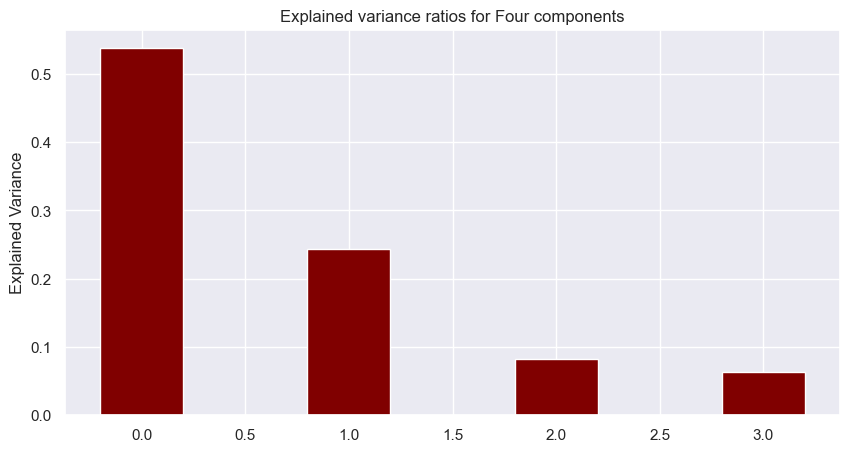

In [4]:
X_matrix = df_combined[['gFx','gFy','gFz','wx','wy','wz']]
y = df_combined.type

trun_svd =  TruncatedSVD(n_components = 4)
print("Select n = 3 components")
X_svd = trun_svd.fit_transform(X_matrix)
print('\nThe size of the X_svd is ' + str(X_svd.shape[0]) + ' by ' + str(X_svd.shape[1]) )
print("\nThe explained_variance is ",trun_svd.explained_variance_)
print("\nThe explained_variance_ratio is ",trun_svd.explained_variance_ratio_)
x = trun_svd.explained_variance_ratio_
print("\nThe explained_variance_ratio_.sum() is ",trun_svd.explained_variance_ratio_.sum())
print("\nThe trun_svd.singular_values ", trun_svd.singular_values_) #n_features_in_
print("\nThe n_features_in_ is ", trun_svd.n_features_in_) #n_features_in_
#print("feature_names_in_ ", trun_svd.feature_names_in_) #n_features_in_

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(range(0,len(trun_svd.explained_variance_ratio_)), trun_svd.explained_variance_ratio_, color ='maroon', width = 0.4)
plt.ylabel("Components")
plt.ylabel("Explained Variance")
plt.title("Explained variance ratios for Four components")
plt.show()

## Plot Clusters of Walking data using SVD

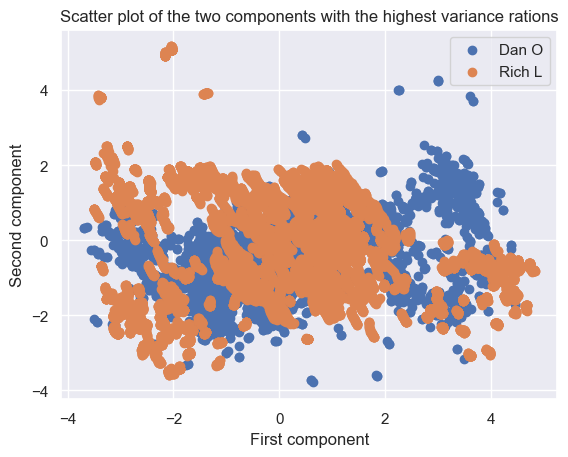

In [5]:
#X_proj = trun_svd.transform(X_matrix)
#print(X_proj.shape[0])
I= df_combined[df_combined['type']=='D'].index
J= df_combined[df_combined['type']=='L'].index
#K= df_combined[df_combined['type']=='C'].index
#print(max(I))
plt.scatter(X_svd[I, 0], X_svd[I, 1])
plt.scatter(X_svd[J, 0], X_svd[J, 1])
#plt.scatter(X_svd[K, 0], X_svd[K, 1])
plt.title('Scatter plot of the two components with the highest variance rations')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.legend(["Dan O","Rich L"])

plt.show()
#X_svd

## Create Stratified Test Train Split
### Scale Data with Zero mean and Unity Variance

In [6]:
X = df_combined.copy(deep = True)
#X.pop('time')
#X.pop('time_elapsed')
y = X.pop('type')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
print('\nThe size of the X_train is ' + str(X_train.shape[0]) + ' by ' + str(X_train.shape[1]) )
print('\nThe size of the X_test is ' + str(X_test.shape[0]) + ' by ' + str(X_test.shape[1]) )
scaler = preprocessing.StandardScaler().fit(X_train)
#min_max_scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


The size of the X_train is 14025 by 6

The size of the X_test is 4676 by 6


In [7]:
Xoriginal = X.copy(deep = True)

## Run a Grid Search to Optimize the MLP Model Parameters
### This takes a long time to run

In [7]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100,early_stopping = True)

#parameter_space = {
#    'hidden_layer_sizes': [(100,), (125,)],
#    'activation': ['tanh', 'relu','logistic'],
#    'solver': ['sgd', 'adam','lbfgs'],
#    'alpha': [0.00001,0.0001],
#    'learning_rate': ['constant'],
#}
#'''
parameter_space = {
    'hidden_layer_sizes': [(100,), (125,)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['lbfgs'],
    'alpha': [0.0001],
    'learning_rate': ['constant'],
}
#'''

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
y_true, y_pred = y_test , clf.predict(X_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(NN.score(X_test,y_pred), 4)
Accuracy_model = round(accuracy_score(y_test, y_pred),4)
plt.title('MLP Classifier Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
#plt.title('MLPClassifier Model Results')
plt.show()

y_pred_proba = NN.predict_proba(np.array(X_test))[:,1]
y_test1 = y_test.replace('D',  0)
y_test1 = y_test1.replace('L',  1)
#y_test1 = y_test1.replace('C',  2)
fpr, tpr, thresholds = roc_curve(y_test1, y_pred_proba)
sns.set()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
AUROC = np.round(roc_auc_score(y_test, y_pred_proba), 3)
plt.title(f'MLPClassifier Model ROC curve; AUROC: {AUROC}');
plt.show()


average_precision = average_precision_score(y_test1, y_pred_proba)
precision, recall, thresholds = precision_recall_curve(y_test1, y_pred_proba)
plt.plot(recall, precision, marker='.', label='MLP')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
average_precision = np.round(average_precision, 3)
plt.title(f'Precision Recall Curve. AUPRC: {average_precision}')
plt.show()

c:\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (125,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.974 (+/-0.003) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.978 (+/-0.005) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (125,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.970 (+/-0.007) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.972 (+/-0.004) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (125,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.951 (+/-0.018) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.945 (+/-0.002) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (125,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
Results on the t

NameError: name 'df_cm' is not defined

<Figure size 640x480 with 0 Axes>

## Create a MLP Classifier Model
### NN = MLPClassifier(activation = "tanh", solver='lbfgs', alpha=0.0001, hidden_layer_sizes=(125, ), learning_rate = "constant", random_state=1,max_iter=200,early_stopping = True)

c:\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


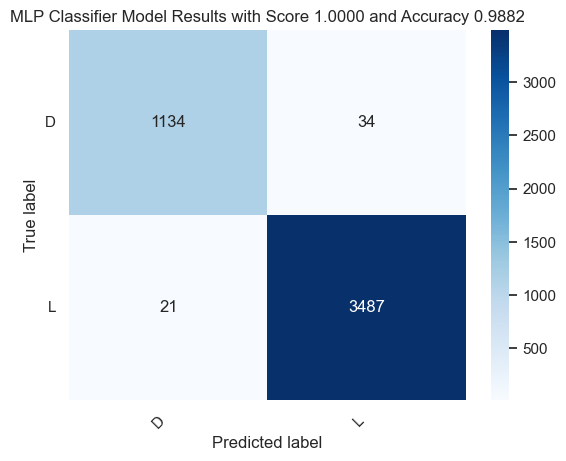

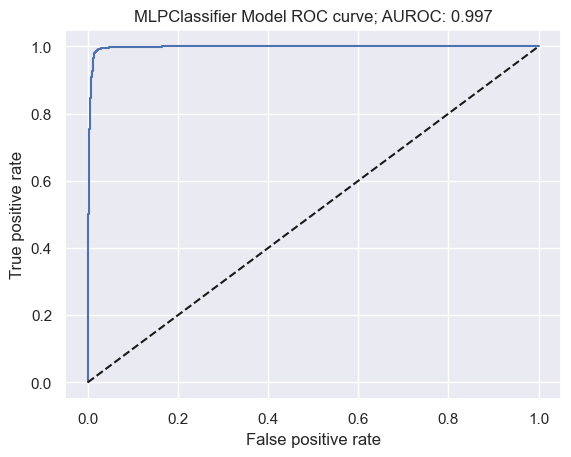

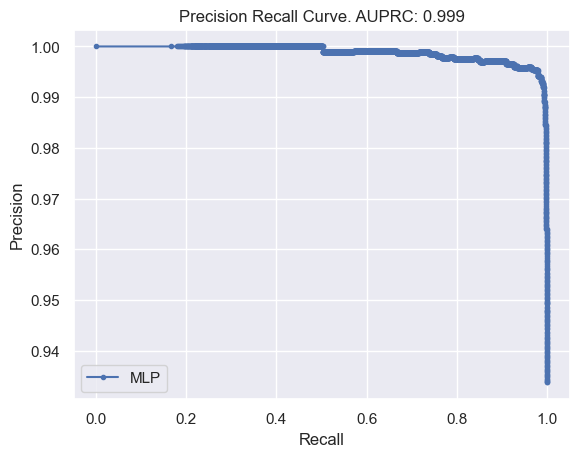

In [8]:
from sklearn.neural_network import MLPClassifier
# {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (125,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
NN = MLPClassifier(activation = "tanh", solver='lbfgs', alpha=0.0001, hidden_layer_sizes=(125, ), learning_rate = "constant", random_state=1,max_iter=200,early_stopping = True)
NN.fit(X_train, y_train)
yhat = NN.predict(X_test)
#print("Score: ", round(NN.score(X_test,yhat), 4))
#print("Accuracy: ", accuracy_score(y_test, yhat))
conmat = confusion_matrix(y_test, yhat)
val = np.mat(conmat) 
classnames = list(set(y_test))
classnames.reverse()
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

#print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(NN.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
plt.title('MLP Classifier Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
plt.show() 

y_pred_proba = NN.predict_proba(np.array(X_test))[:,1]
y_test1 = y_test.replace('D',  0)
y_test1 = y_test1.replace('L',  1)
#y_test1 = y_test1.replace('C',  2)
fpr, tpr, thresholds = roc_curve(y_test1, y_pred_proba)
sns.set()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
AUROC = np.round(roc_auc_score(y_test, y_pred_proba), 3)
plt.title(f'MLPClassifier Model ROC curve; AUROC: {AUROC}');
plt.show()


average_precision = average_precision_score(y_test1, y_pred_proba)
precision, recall, thresholds = precision_recall_curve(y_test1, y_pred_proba)
plt.plot(recall, precision, marker='.', label='MLP')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
average_precision = np.round(average_precision, 3)
plt.title(f'Precision Recall Curve. AUPRC: {average_precision}')
plt.show()

## Experimenting with adding a low pass filter

In [9]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_highpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass_filter(data, cutoff_low, cuttoff_high, fs, order):
    normal_cutoff_low = cutoff_low / nyq
    normal_cutoff_high = cutoff_high / nyq    
    # Get the filter coefficients 
    b, a = butter(order, [normal_cutoff_low,normal_cutoff_high], btype='band', analog=False)
    y = filtfilt(b, a, data)
    return y

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)


## Add a Third Walker

In [59]:
#display(HTML("<script>$('div.cell.selected').children('div.output_wrapper').height(800);</script>"))
df_stairs = pd.DataFrame(columns=['time','gFx','gFy','gFz','wx','wy','wz','Unnamed: 7','time_elapsed'])
df_walking = pd.DataFrame(columns=['time','gFx','gFy','gFz','wx','wy','wz','Unnamed: 7','time_elapsed'])
df_sitting = pd.DataFrame(columns=['time','gFx','gFy','gFz','wx','wy','wz','Unnamed: 7','time_elapsed'])

data_path = os.path.join(notebook_path, "data\\dan-raw")
os.chdir(data_path)

#os.chdir('./Stairs')
# Get the list of all files and directories
for x in os.listdir():
    if x.endswith("walking normally.csv"):
        df = pd.read_csv(x)
        df['time_elapsed'] = round(df['time']*1e6)
        df['type'] = 'D'
        df_stairs = df_stairs.append(df, ignore_index=True) 
df_stairs = df_stairs.drop('Unnamed: 7', axis=1) 
df_stairs.reset_index(inplace = True,drop=True)
df_stairs = df_stairs.dropna(axis = 0, how ='any')
print(df_stairs.shape)

data_path = os.path.join(notebook_path, "data\\richard-raw\\Logs_walking_straight")
os.chdir(data_path)

# Get the list of all files and directories
for x in os.listdir():
    if x.endswith("Hard.csv"):
        df = pd.read_csv(x)
        df['time_elapsed'] = round(df['time']*1e6)
        df['type'] = 'L'
        df_walking = df_walking.append(df, ignore_index=True) 
df_walking = df_walking.drop('Unnamed: 7', axis=1) 
df_walking = df_walking.dropna(axis = 0, how ='any')
df_walking.reset_index(inplace = True,drop=True)
print(df_walking.shape)

data_path = os.path.join(notebook_path, "data\\george-raw\\Modified")
os.chdir(data_path)

# Get the list of all files and directories
for x in os.listdir():
    if x.endswith(".csv"):
        df = pd.read_csv(x)
        df['time_elapsed'] = (df['time'])
        df['type'] = 'G'
        df_sitting = df_sitting.append(df, ignore_index=True) 
df_sitting = df_sitting.drop('Unnamed: 7', axis=1) 
df_sitting = df_sitting.dropna(axis = 0, how ='any')
df_sitting.reset_index(inplace = True,drop=True)
print(df_sitting.shape)

df_combined3 = pd.concat([df_walking, df_stairs, df_sitting])
df_combined3 = df_combined3.drop('time', axis=1)
df_combined3 = df_combined3.drop('time_elapsed', axis=1)
df_combined3.reset_index(inplace = True,drop=True)

print("DataFrames Created")




(4671, 9)
(14030, 9)
(18549, 9)
DataFrames Created


## Create a Sliding Window of Input Vectors using a lagged input

In [58]:
X = df_combined3.copy(deep = True)

if True:
    X['gFxm1'] = X['gFx']
    X['gFym1'] = X['gFy']
    X['gFzm1'] = X['gFz']

    X['gFxm1'].iloc[1:] = X['gFx'].iloc[0:-1]
    X['gFym1'].iloc[1:] = X['gFy'].iloc[0:-1]
    X['gFzm1'].iloc[1:] = X['gFz'].iloc[0:-1]

if False:
    X['wxm1'] = X['wx']
    X['wym1'] = X['wy']
    X['wzm1'] = X['wz']

    X['wxm1'].iloc[1:] = X['wx'].iloc[0:-1]
    X['wym1'].iloc[1:] = X['wy'].iloc[0:-1]
    X['wzm1'].iloc[1:] = X['wz'].iloc[0:-1]

y = X.pop('type')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
print('\nThe size of the X_train is ' + str(X_train.shape[0]) + ' by ' + str(X_train.shape[1]) )
print('\nThe size of the X_test is ' + str(X_test.shape[0]) + ' by ' + str(X_test.shape[1]) )
scaler = preprocessing.StandardScaler().fit(X_train)
#min_max_scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


The size of the X_train is 27937 by 9

The size of the X_test is 9313 by 9


c:\python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


c:\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


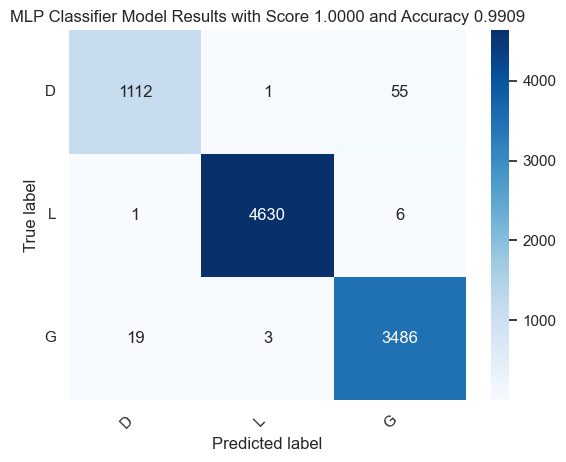

In [16]:
from sklearn.neural_network import MLPClassifier
# {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (125,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
NN = MLPClassifier(activation = "tanh", solver='lbfgs', alpha=0.0001, hidden_layer_sizes=(125, ), learning_rate = "constant", random_state=1,max_iter=200,early_stopping = True)
NN.fit(X_train, y_train)
yhat = NN.predict(X_test)
#print("Score: ", round(NN.score(X_test,yhat), 4))
#print("Accuracy: ", accuracy_score(y_test, yhat))
conmat = confusion_matrix(y_test, yhat)
val = np.mat(conmat) 
classnames = list(set(y_test))
classnames.reverse()
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

#print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(NN.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
plt.title('MLP Classifier Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
plt.show() 

## Create a 15 element input vector consisting of wx,wy,wz gz,gy,gz wxm1... gzm1... and EWMA valus of wx,wy,wz for alpha = 0.1

In [60]:
X = df_combined3.copy(deep = True)

if True:
    X['gFxm1'] = X['gFx']
    X['gFym1'] = X['gFy']
    X['gFzm1'] = X['gFz']

    X['gFxm1'].iloc[1:] = X['gFx'].iloc[0:-1]
    X['gFym1'].iloc[1:] = X['gFy'].iloc[0:-1]
    X['gFzm1'].iloc[1:] = X['gFz'].iloc[0:-1]

if True:
    X['wxm1'] = X['wx']
    X['wym1'] = X['wy']
    X['wzm1'] = X['wz']

    X['wxm1'].iloc[1:] = X['wx'].iloc[0:-1]
    X['wym1'].iloc[1:] = X['wy'].iloc[0:-1]
    X['wzm1'].iloc[1:] = X['wz'].iloc[0:-1]
    
if True:
    X['wxE'] = X['wx']
    X['wyE'] = X['wy']
    X['wzE'] = X['wz']   
    
    alpha = 0.1
    for i in range(1,len(X['wx'])):
        X['wxE'].loc[i] = round(alpha*X['wx'].loc[i] + (1-alpha)*X['wxE'].loc[i-1],4)
        X['wyE'].loc[i] = round(alpha*X['wy'].loc[i] + (1-alpha)*X['wyE'].loc[i-1],4)
        X['wzE'].loc[i] = round(alpha*X['wz'].loc[i] + (1-alpha)*X['wzE'].loc[i-1],4)
        

y = X.pop('type')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
print('\nThe size of the X_train is ' + str(X_train.shape[0]) + ' by ' + str(X_train.shape[1]) )
print('\nThe size of the X_test is ' + str(X_test.shape[0]) + ' by ' + str(X_test.shape[1]) )
scaler = preprocessing.StandardScaler().fit(X_train)
#min_max_scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

c:\python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)



The size of the X_train is 27937 by 15

The size of the X_test is 9313 by 15


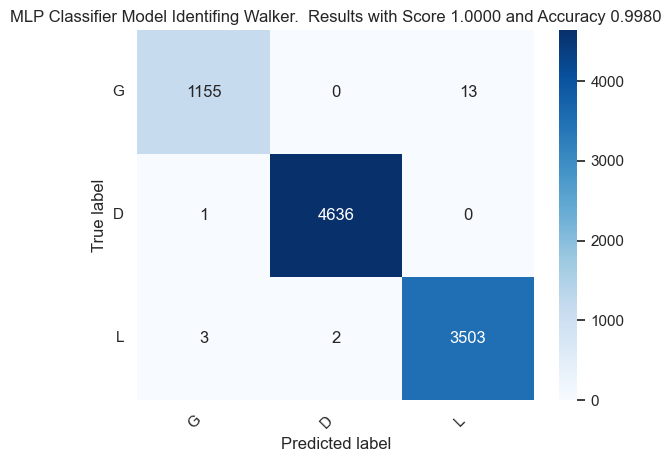

In [61]:
from sklearn.neural_network import MLPClassifier
# {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (125,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
NN = MLPClassifier(activation = "tanh", solver='lbfgs', alpha=0.0001, hidden_layer_sizes=(125, ), learning_rate = "constant", random_state=1,max_iter=200,early_stopping = True)
NN.fit(X_train, y_train)
yhat = NN.predict(X_test)
#print("Score: ", round(NN.score(X_test,yhat), 4))
#print("Accuracy: ", accuracy_score(y_test, yhat))
conmat = confusion_matrix(y_test, yhat)
val = np.mat(conmat) 
classnames = list(set(y_test))
classnames.reverse()
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

#print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(NN.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
plt.title('MLP Classifier Model Identifing Walker.  Uses Lagged inputs and a LPF. Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
plt.show() 